In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from matplotlib.ticker import MultipleLocator

from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', None)

### Načítanie .txt súboru

In [2]:
df = pd.read_table("quest_data/power_consumption.txt",sep=';', dtype=str, low_memory=False)

#
# **4.1 EDA and data preprocessing**

#### **`Active power`** - skutočná energia, ktorá sa v sieti využíva.
#### **`Reactive power`** - nepoužitá energia, ktorá iba prúdi v sieti.
#### **`Apparent power`** - celková energia, ktorá je v sieti prítomná.
#### **`Sub_metering_1`** - energia spotrebovaná v kuchyni: umývačku riadu, rúra a mikrovlnná rúra.
#### **`Sub_metering_2`** - energia spotrebovaná v práčovni: práčka, sušička, chladnička a svetlo.
#### **`Sub_metering_3`** - energia spotrebovaná: elektrický ohrievač vody a klimatizácia.

#
## *A) EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu*

### Názvy atribútov

In [3]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### Prvý pohľad na dáta

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


### Zíkladné info o datasete

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [6]:
df.describe(include='all')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2049280
unique,1442,1440,4187,533,2838,222,89,82,32
top,6/12/2008,17:24:00,?,0.000,?,1.000,0.000,0.000,0.000
freq,1440,1442,25979,481561,25979,172785,1880175,1436830,852092


### Môžeme vidieť, že niektoré záznamy ako hodnotu majú: `?`. Pre každý atribút zistíme, koľko `?` obsahuje.

In [7]:
for col in df.columns:
    count = df[col].str.contains(r'\?', na=False).sum()
    print(f"{col:<22}: {count}")

print(f"\n{'Columns 3-8':<22}: {df[df.columns[2:-1]].apply(lambda col: col.str.contains(r'\?', na=False)).all(axis=1).sum()}")

Date                  : 0
Time                  : 0
Global_active_power   : 25979
Global_reactive_power : 25979
Voltage               : 25979
Global_intensity      : 25979
Sub_metering_1        : 25979
Sub_metering_2        : 25979
Sub_metering_3        : 0

Columns 3-8           : 25979


#### Atribúty 3 až 8 obsahujú rovnaký počet `?`. Overili sme, že ak záznam obsahuje v ktoromkoľvek atribúte hodnotu: `?`, tak či všetky dalšie atribúty (3 až 8) takisto obsahujú `?` v danom zázname. Potvrdilo sa to!

### Keďže takéto záznamy s `?` nemajú žiadnu hodnotu, tak ich vymažeme.

In [8]:
df = df[~df.apply(lambda col: col.map(lambda x: '?' in str(x))).any(axis=1)]

### Overíme duplicitné záznamy.

In [9]:
df.duplicated().sum()

0

### Overíme chýbajúce hodnoty.

In [10]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Atribúty `Date` a `Time` spojíme do nového atribútu `DateTime` a pretypujeme na `datetime64`.

In [11]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

### `DateTime` presunieme na začiatok; `Date` a `Time` môžeme vymazať.

In [12]:
df.insert(0, 'DateTime', df.pop('DateTime'))
df.drop(columns=['Date', 'Time'], inplace=True)

### Keďže pracujeme s číselnými hodnotami, tak pretypujeme atribúty na zodpovedajúce typy: `float` a `int`.

In [13]:
for column in df.columns[1:-3]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(float)

for column in df.columns[-3:]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(int)

### Zobrazíme korelácie atribútov na `Heat-Map`. 

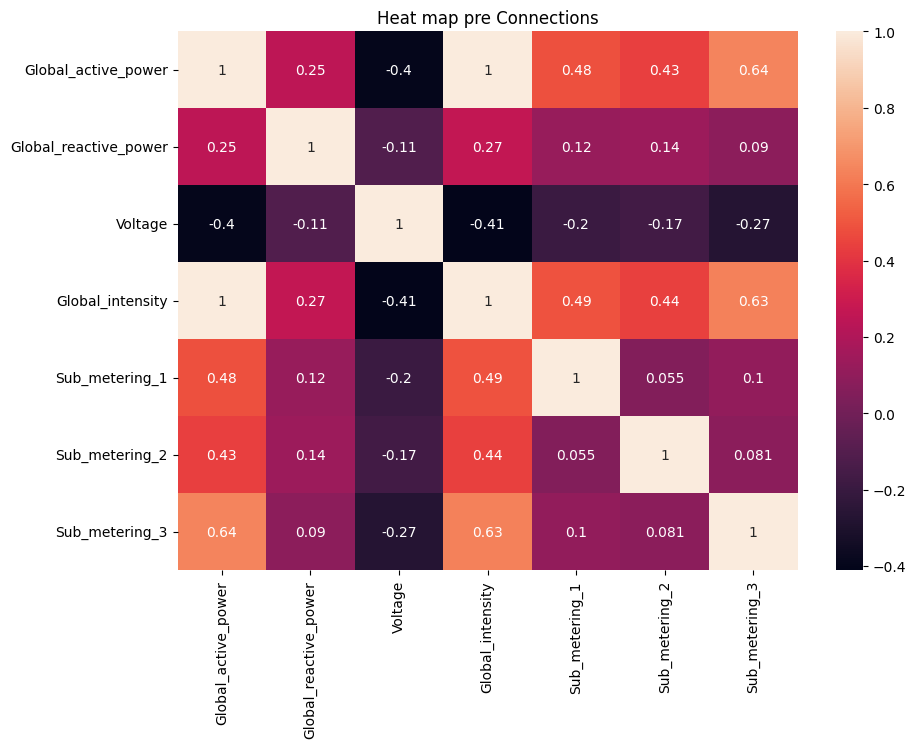

In [14]:
df_corr=df.iloc[:, 1:].corr()

fig, ax = plt.subplots(figsize=(10,7))

ax.set_title('Heat map pre Connections', fontsize=12)

sns.heatmap(df_corr, annot=True)
plt.show()

### Zoradíme záznamy podľa času merania (už teraz vyzerajú byť zoradené), aby sme mali istotu.

In [15]:
df = df.sort_values(by='DateTime')

### Počet meraní pre jednotlivé roky z datasetu.

In [16]:
for year, count in df.groupby(df['DateTime'].dt.year).size().items():
    print(f'{year} : {count:,}')

2006 : 21,992
2007 : 521,669
2008 : 526,905
2009 : 521,320
2010 : 457,394


#### Roky `2006` a `2010` obsahujú "výrazne" menej meraní ako zvyšné roky, čo je však logické, pretože merania netrvali celé dané roky. Na druhej strane roky `2007`, `2008`, `2009` majú "zhruba" podobný počet meraní. Musíme však ešte brať do úvahy, že sme takmer 26,000 neplatných záznamov vymazali.

#
#### `Funkcia:` Zobrazenie priemernej ___ power za dané obdobie.

In [ ]:
def show_power_graph(df, by):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df, x='DateTime', y='Global_active_power', color='#10375C')

    plt.title(f'Priemerná {by}spotreba energie počas obdobia 12/2006 - 10/2010', fontsize=16)
    plt.xlabel('Obdobie', fontsize=12)
    plt.ylabel('Priemerná spotreba energie', fontsize=12)
    plt.xticks()
    plt.tight_layout()
    plt.show()

### Priemerná spotreba `Global_active_power` každú minútu.

In [18]:
# show_power_graph(df=df, by="")

### Priemerná spotreba `Global_active_power` každý deň.

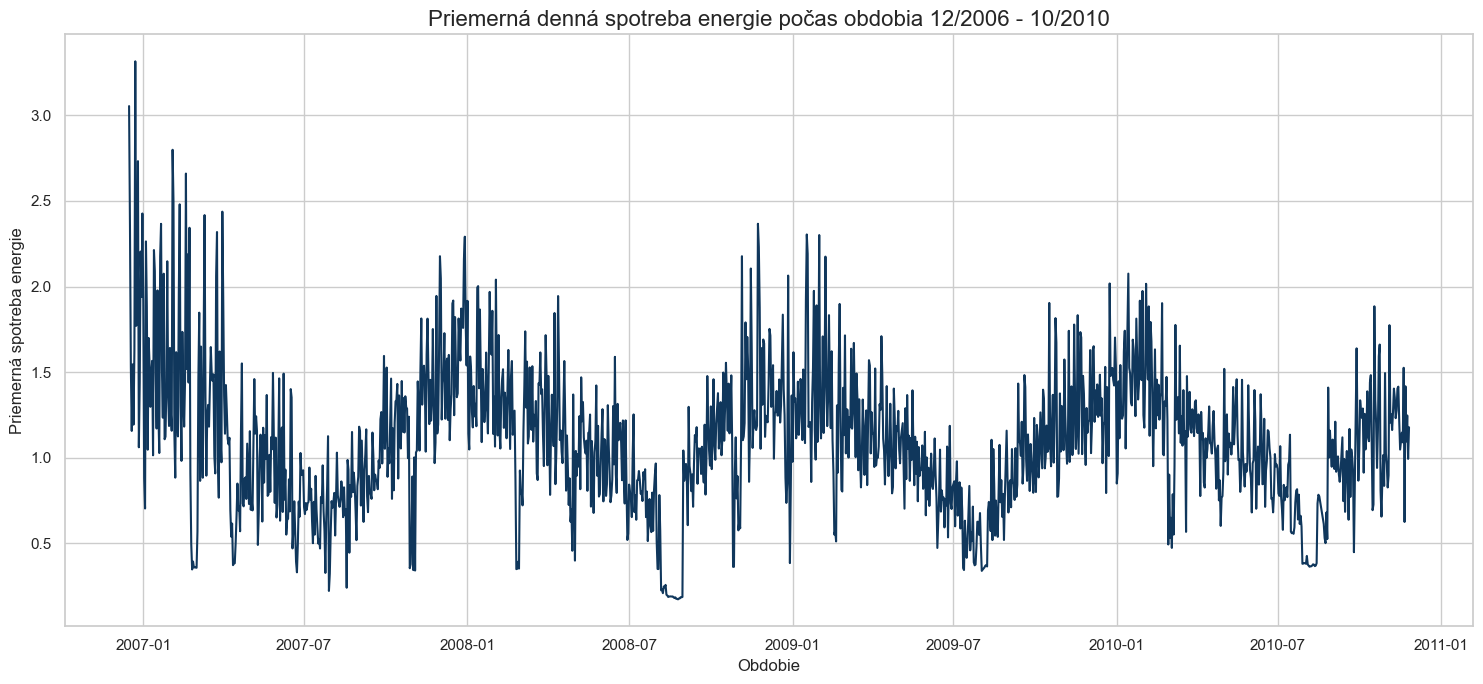

In [19]:
df_daily = df.resample('D', on='DateTime').mean()
show_power_graph(df=df_daily, by="denná ")

### Priemerná spotreba `Global_active_power` každý mesiac.

In [20]:
# df_monthly = df.resample('ME', on='DateTime').mean()
# show_power_graph(df=df_monthly, by="mesačná ")

#### `Funkcia:` Porovanie 2 atribútov za jednotlivé roky na `bar-plote`.

In [21]:
def attributes_comparison(attr1, type1, attr2, type2):
    df_comparison = df.resample('YE', on='DateTime')[[attr1, attr2]].sum()

    active_color = '#10375C'
    reactive_color = '#EB8317'
    width = 0.35
    x = df_comparison.index.year

    plt.figure(figsize=(14, 7))

    plt.bar(x - width / 2, df_comparison[attr1], width=width, color=active_color, label=f'{attr1} ({type1})')
    plt.bar(x + width / 2, df_comparison[attr2], width=width, color=reactive_color, label=f'{attr2} ({type2})')

    for i, (active, reactive) in enumerate(zip(df_comparison[attr1], df_comparison[attr2])):
        plt.text(x[i] - width / 2, active + 0.1, f'{active:,.0f}', ha='center', va='bottom', fontsize=10, color=active_color)
        plt.text(x[i] + width / 2, reactive + 0.1, f'{reactive:,.0f}', ha='center', va='bottom', fontsize=10, color=reactive_color)

    plt.title(f'Porovnanie súčtov ({attr1} a {attr2}) podľa rokov', fontsize=16)
    plt.xlabel('Rok', fontsize=12)
    plt.ylabel('Rozsah', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

#
### Porovnanie `Global_active_power` a `Global_reactive_power` pre jednotlivé roky.

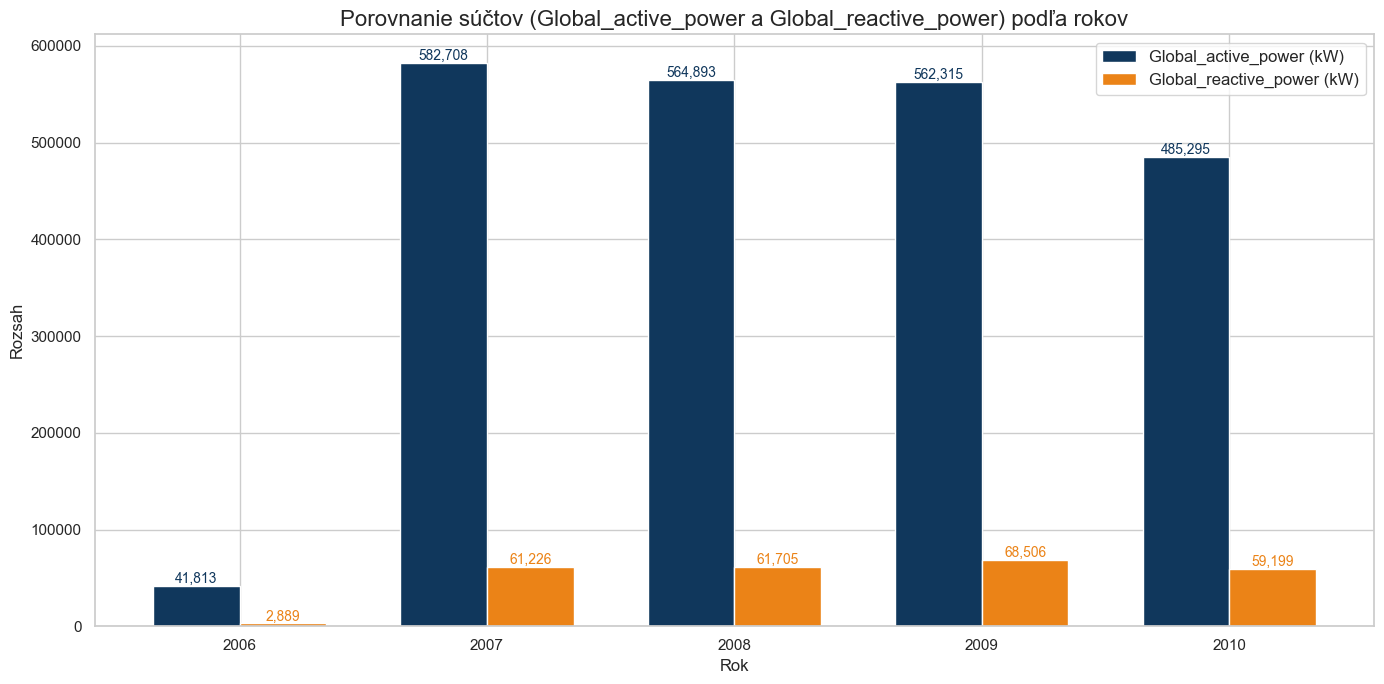

In [22]:
attributes_comparison(attr1='Global_active_power', type1='kW', attr2='Global_reactive_power', type2='kW')

#
### Porovnanie `Sub_metering_1` a `Sub_metering_2` pre jednotlivé roky.

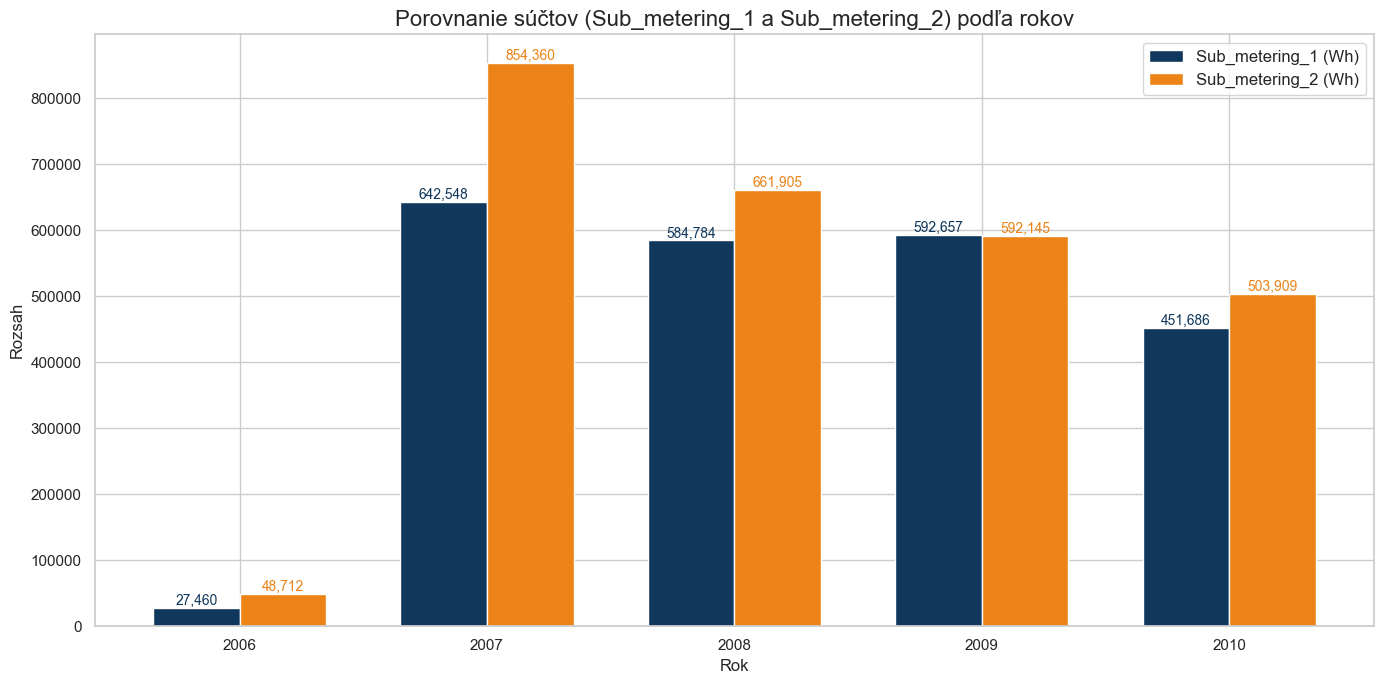

In [23]:
attributes_comparison(attr1='Sub_metering_1', type1='Wh', attr2='Sub_metering_2', type2='Wh')

### Vypočítanie `Apparent_power` pre vypočítanie `Efficiency`.

In [ ]:
df['Apparent_power'] = np.sqrt(df['Global_active_power']**2 + df['Global_reactive_power']**2).round(3)
df['Efficiency'] = (df['Global_active_power'] / df['Apparent_power'] * 100).round(2)

### Presun nových atribútov.

In [25]:
df.insert(3, 'Apparent_power', df.pop('Apparent_power'))
df.insert(4, 'Efficiency', df.pop('Efficiency'))

### Celkové sčítané hodnoty jednotlivých atribútov pre jednotlivé roky.

In [27]:
df.resample('YE', on='DateTime').sum().astype(int)

,Global_active_power,Global_reactive_power,Apparent_power,Efficiency,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,,
2006-12-31,41813,2889,42093,2155323,5309773,176594,27460,48712,162951
2007-12-31,582708,61225,591675,50177937,124879155,2485492,642548,854360,3022840
2008-12-31,564893,61705,574055,50699947,126787268,2398458,584784,661905,3179187
2009-12-31,562315,68505,572511,50175016,126104354,2374625,592657,592145,3556816
2010-12-31,485295,59199,493451,44278459,110467752,2048404,451686,503909,3313373


#
### Zobrazenie efektivity energie za jednotlivé roky.

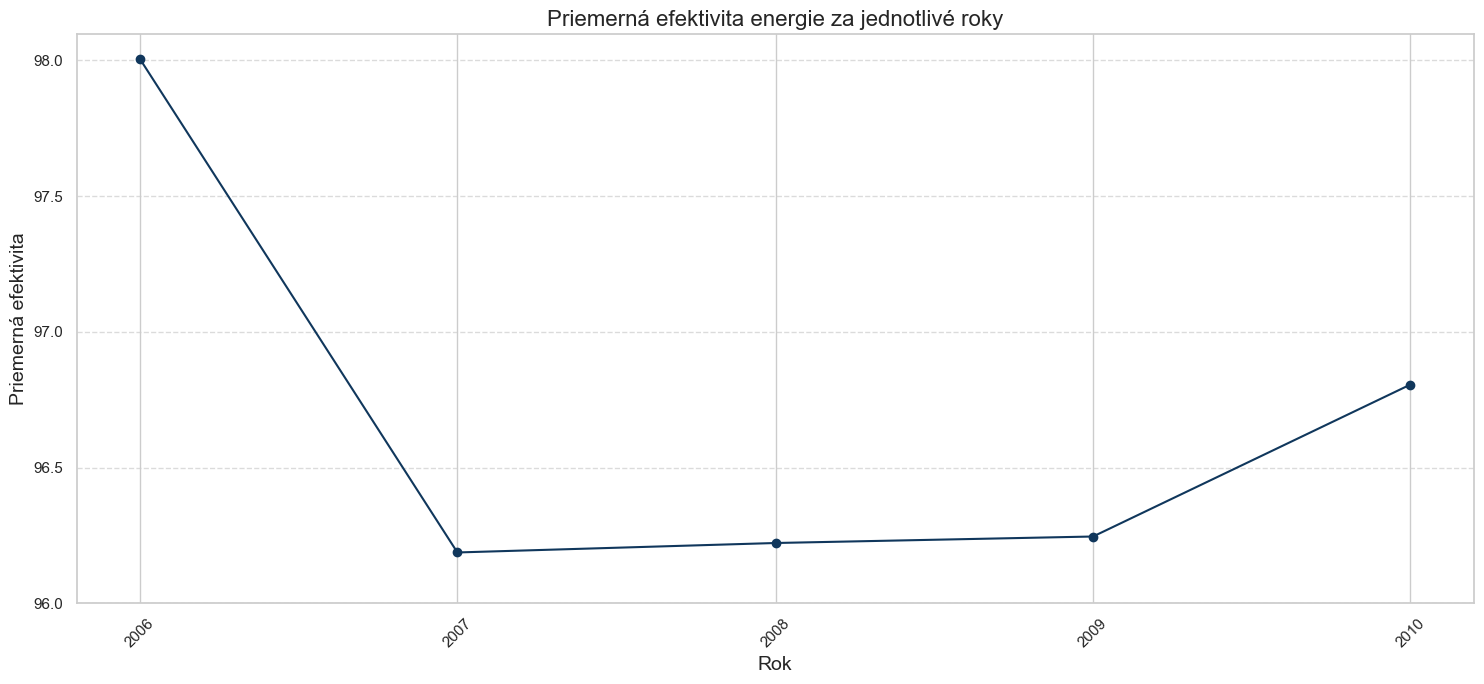

In [ ]:
df_efficiency = df.resample('YE', on='DateTime')[['Efficiency']].mean()
df_efficiency = df_efficiency.reset_index()

plt.figure(figsize=(15, 7))
plt.plot(df_efficiency['DateTime'], df_efficiency['Efficiency'], marker='o', linestyle='-', color='#10375C')
plt.title('Priemerná efektivita energie za jednotlivé roky', fontsize=16)
plt.xlabel('Rok', fontsize=14)
plt.ylabel('Priemerná efektivita', fontsize=14)
plt.xticks(df_efficiency['DateTime'], df_efficiency['DateTime'].dt.year, rotation=45)
plt.ylim(96, None)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#
## *B) Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2*

#
# **4.2 Modeling and evaluation**

#
## *A) Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model*

#
## *B) Zhodnotíte Váš prístup a získaný výsledok*